# Offshore CIOPS Quantitative Runs

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import datetime as dt
import math

### general variables:

In [4]:
mymesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [3]:
Wdata17 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
Sdata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
Wdata16 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')

In [3]:
#in the format [section, igridW, igridE, fjgrid, maxdepth] for horizontal CS
# OR for vertical [section, jgridS, jgridN, figrid, maxdepth]
init = [1,259, 274, 640,250] #v
North = [2, 531, 585, 320, 220] #h
Sshelf = [5, 634, 644, 200, 180] #h
Sslope = [4, 579, 633, 200, 500] #h
offshore = [3, 199, 300, 560, 500] # v

In [4]:
salfileS17 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20170401_20170930.nc')
salfileW16 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20161001_20170331.nc')
salfileW17 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20171001_20180331.nc')

### general functions:

In [5]:
# sig figs
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

In [6]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(len(t_depths)-1):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', zorder=3)
    return(pc)

# Total Flow

In [7]:
def FluxEW(mydata, salfile, tracername, section, lonW, lonE, fjgrid, maxdepth, distlabel, ax, title):
    igrid = fjgrid-1
    fmask = mymesh.fmask[0, :, igrid, :]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[lonW-1:lonE+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist[lonW-1:lonE+1]), np.array(t_depths))
    
    if type(section) == list:
        lons = mydata.final_lon[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
        dist = lons/m2lon
        depths = depthf(mydata.final_z[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]-1.)[0]
        transports = mydata.final_transp[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]/time
        
        H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= transports, density= True)
        _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
        if tracername == 'trans':
            t_max = (0.01/np.sum(transports)).values
            tick = np.round(((t_max*sum(transports)).values),2)
            cmap = cm.speed
            units = '$m s^{-1}$'
            
            H_final = H1.T
    
        elif tracername == 'temp' or tracername == 'salt':
            if tracername == 'temp':
                tracer = mydata.init_temp[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
                t_max = round(1 * 0.1,1)
                tick = t_max
                cmap = cm.rain
                units = '$C^{\circ} m s^{-1}$'
            else:
                tracer = mydata.init_salt[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
                t_max = round(15 * 0.1,1)
                tick = t_max
                cmap = cm.amp
                units = '$g kg^{-1} m s^{-1}$'
        
            H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths])
            H_final = H1.T * H.statistic.T * float(sum(transports))
    
        else:
            print('incorrect tracer name, options are trans, salt, temp')
            
    else:
        lons = mydata.final_lon[(mydata.final_section==section)]
        dist = lons/m2lon
        depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
        transports = mydata.final_transp[(mydata.final_section==section)]/time
        
        H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= transports, density= True)
        _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
        if tracername == 'trans':
            t_max = (0.01/np.sum(transports)).values
            tick = np.round(((t_max*sum(transports)).values),2)
            cmap = cm.speed
            units = '$m \, s^{-1}$'
            
            H_final = H1.T
    
        elif tracername == 'temp' or tracername == 'salt':
            if tracername == 'temp':
                tracer = mydata.init_temp[(mydata.final_section == section)]
                t_max = round(1 * 0.1,1)
                tick = t_max
                cmap = cm.rain
                units = '$C^{\circ} m s^{-1}$'
            else:
                tracer = mydata.init_salt[(mydata.final_section == section)]
                t_max = round(15 * 0.1,1)
                tick = t_max
                cmap = cm.amp
                units = '$g kg^{-1} m s^{-1}$'
        
            H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths])
            H_final = H1.T * H.statistic.T * float(sum(transports))
    
        else:
            print('incorrect tracer name, options are trans, salt, temp')

    X, Y = np.meshgrid(xedges, yedges)
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick]) 
    cb1.set_label(units, labelpad=-20, fontsize=14)
    
    salinity = 0.5*(np.ma.array(salfile.vosaline[:, igrid, lonW-1:lonE+1],
            mask=1-tmask[:, igrid, lonW-1:lonE+1]) +
            np.ma.array(salfile.vosaline[:, igrid+1, lonW-1:lonE+1],
            mask=1-tmask[:, igrid+1, lonW-1:lonE+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12)
#     ax.legend(fontsize=12)

    if distlabel == True:
        distance = abs(round_to_3((t_dist[lonW-1]-t_dist[lonE+1]).values/1000))
        ax.set_xlabel("Cross-section width = "+str(distance)[:-2]+" km", fontsize=14)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW], t_dist[lonE-1]])
    ax.set_xticklabels(np.round([t_lons[lonW], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE-1]))
    ax.set_ylim((maxdepth, 0))
    full_title = str(title)+" - "+str(round_to_2(np.sum(transports).values))[:-2]+" $m^3 \, s^{-1}$"
    ax.set_title(str(full_title), fontsize=16)
    ax.set_ylabel('Depth [m]', fontsize=14)
    mydata.close()
    
    return t_dist

In [8]:
def FluxNS(mydata, salfile, tracername, section, latS, latN, figrid, maxdepth, distlabel, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist[latS-1:latN+1]), np.array(t_depths))
    
    lats = mydata.final_lat[(mydata.final_section==section)]
    dist = lats/m2lat
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    bins = [np.array(t_dist[latS-1:latN+1]), t_depths]
    H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
    if tracername == 'trans':
        t_max = (0.01/np.sum(transports)).values
        tick = np.round(((t_max*sum(transports)).values),2)
        cmap = cm.speed
        units = '$m \, s^{-1}$'
        
        H_final = H1.T
    
    elif tracername == 'temp' or tracername == 'salt':
        if tracername == 'temp':
            tracer = mydata.init_temp[(mydata.final_section == section)]
            t_max = round(1 * 0.1,1)
            tick = t_max
            cmap = cm.rain
            units = '$C^{\circ} m s^{-1}$'
        else:
            tracer = mydata.init_salt[(mydata.final_section == section)]
            t_max = round(15 * 0.1,1)
            tick = t_max
            cmap = cm.amp
            units = '$g kg^{-1} m s^{-1}$'
        
        H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
        H_final = H1.T * H.statistic.T * float(sum(transports))
    
    else:
        print('incorrect tracer name, options are trans, salt, temp')
    
    if section == 3:
        h= H_final
        h[:,19] = H_final[:,19]/15
        h[:,20] = H_final[:,20]/15
        h[:,21] = H_final[:,21]/10
        h[:,41] = H_final[:,41]/10
        h[:,61] = H_final[:,61]/8
        h[:,62] = H_final[:,62]/8
        h[:,83] = H_final[:,83]/10
        h[:,84] = H_final[:,84]/10
        H_final = np.where(h>0, h, h*np.nan)
    else:
        H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick], fontsize=12)
    cb1.set_label(units, labelpad=-20, fontsize=14)
    
    if distlabel == True:
        distance = abs(round_to_3((t_dist[latS-1]-t_dist[latN+1]).values/1000))
        ax.set_xlabel("Cross-section width = "+str(distance)[:-2]+" km", fontsize=14)
    
    salinity = 0.5*(np.ma.array(salfile.vosaline[:, latS-1:latN+1, igrid],
        mask=1-tmask[:, latS-1:latN+1, igrid]) +
        np.ma.array(salfile.vosaline[:, latS-1:latN+1, igrid+1],
        mask=1-tmask[:, latS-1:latN+1, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12)
#     ax.legend(fontsize=12)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
    full_title = str(title)+" - "+str(round_to_2(np.sum(transports).values))[:-2]+" $m^3 \, s^{-1}$"
    ax.set_title(str(full_title), fontsize=16)
    ax.set_ylabel('Depth [m]', fontsize=14)
    mydata.close()

In [ ]:
def JRFluxNS(mydata, salfile, tracername,latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    lats = mydata.init_lat[(mydata.final_section != 0)]
    dist = lats/m2lat
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    bins = [np.array(t_dist[latS-1:latN+1]), t_depths]
    H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
    if tracername == 'trans':
        t_max = (0.05/np.sum(transports)).values
        tick = np.round(((t_max*sum(transports)).values),2)
        cmap = cm.speed
        units = '$m s^{-1}$'
        
        H_final = H1.T
    
    elif tracername == 'temp' or tracername == 'salt':
        if tracername == 'temp':
            tracer = mydata.init_temp[(mydata.final_section != 0)]
            t_max = round(1 * 0.1,1)
            tick = t_max
            cmap = cm.rain
            units = '$C^{\circ} m s^{-1}$'
        else:
            tracer = mydata.init_salt[(mydata.final_section != 0)]
            t_max = round(15 * 0.1,1)
            tick = t_max
            cmap = cm.amp
            units = '$g kg^{-1} m s^{-1}$'
        
        H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
        H_final = H1.T * H.statistic.T * float(sum(transports))
    
    else:
        print('incorrect tracer name, options are trans, salt, temp')
    
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick])
    cb1.set_label(units, labelpad=-20)
    
    salinity = 0.5*(np.ma.array(salfile.vosaline[0, :, :, igrid],
        mask=1-tmask[:, :, igrid]) +
        np.ma.array(salfile.vosaline[0, :, :, igrid+1],
        mask=1-tmask[:, :, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,34.5, 0.5), colors='b', zorder = 2)
    ax.clabel(CS, inline=1, fontsize=7)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    ax.set_ylabel('Depth [m]')
    mydata.close()

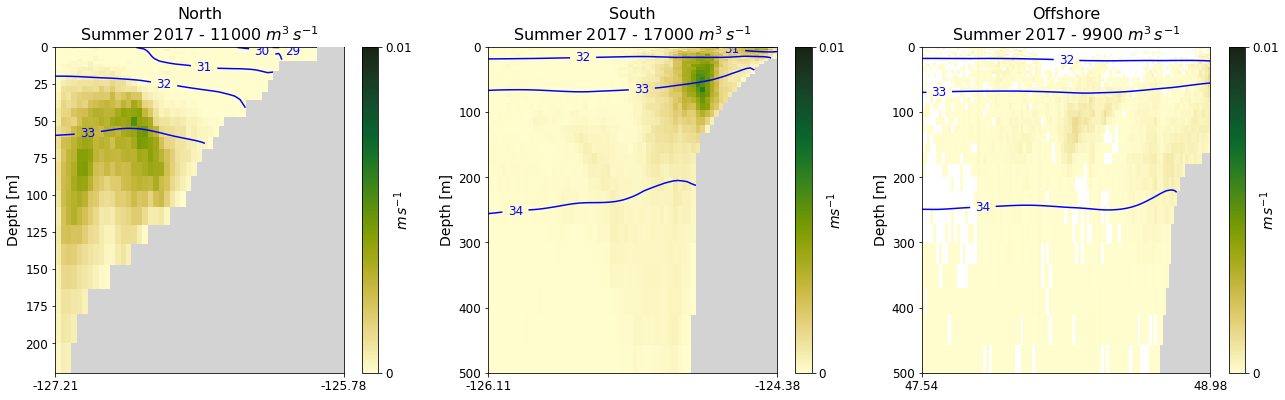

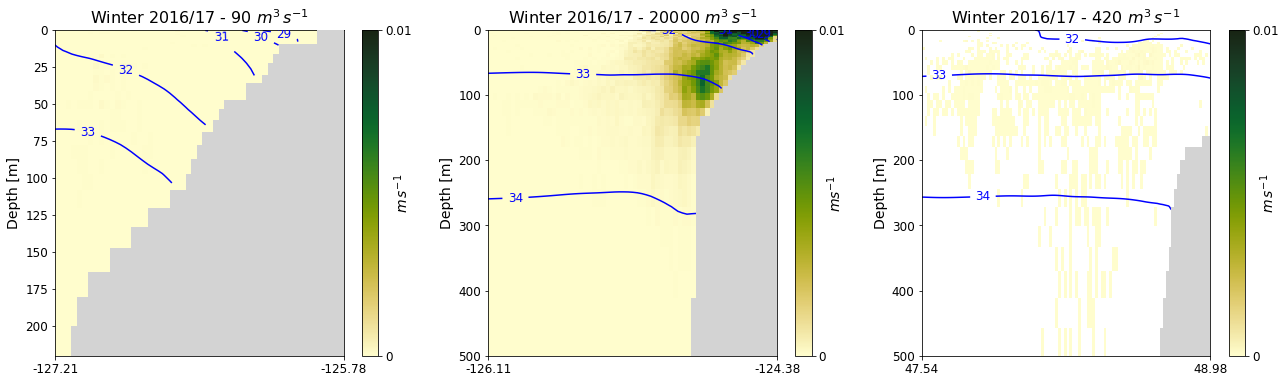

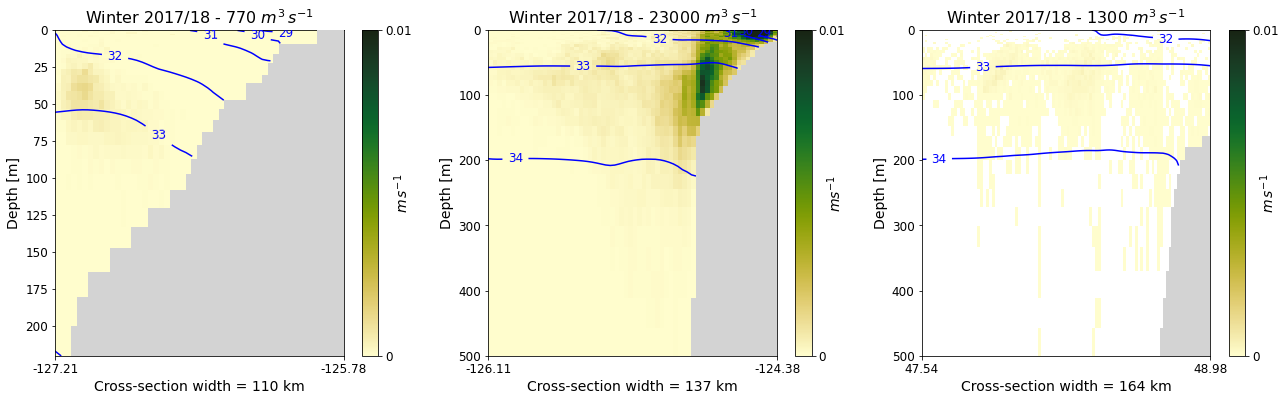

In [10]:
# one presentable figure with all the offshore stuff for the three seasons togetha
plt.rcParams['font.size'] = 12

distlabel = False
fig, ax = plt.subplots(1,3, figsize=[22,6])
t_dist = FluxEW(Sdata, salfileS17, 'trans', North[0], North[1], North[2], North[3], North[4], distlabel, ax[0], 'North\nSummer 2017')
t_dist = FluxEW(Sdata, salfileS17, 'trans', [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax[1], 'South\nSummer 2017')
FluxNS(Sdata, salfileS17, 'trans', offshore[0], offshore[1], offshore[2], offshore[3], offshore[4], distlabel, ax[2], 'Offshore\nSummer 2017')

fig, ax = plt.subplots(1,3, figsize=[22,6])
t_dist = FluxEW(Wdata16, salfileW16, 'trans', North[0], North[1], North[2], North[3], North[4], distlabel, ax[0], 'Winter 2016/17')
t_dist = FluxEW(Wdata16, salfileW16, 'trans', [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax[1], 'Winter 2016/17')
FluxNS(Wdata16, salfileW16, 'trans', offshore[0], offshore[1], offshore[2], offshore[3], offshore[4], distlabel, ax[2], 'Winter 2016/17')

distlabel = True
fig, ax = plt.subplots(1,3, figsize=[22,6])
t_dist = FluxEW(Wdata17, salfileW17, 'trans', North[0], North[1], North[2], North[3], North[4], distlabel, ax[0], 'Winter 2017/18')
t_dist = FluxEW(Wdata17, salfileW17, 'trans', [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax[1], 'Winter 2017/18')
FluxNS(Wdata17, salfileW17, 'trans', offshore[0], offshore[1], offshore[2], offshore[3], offshore[4], distlabel, ax[2], 'Winter 2017/18')

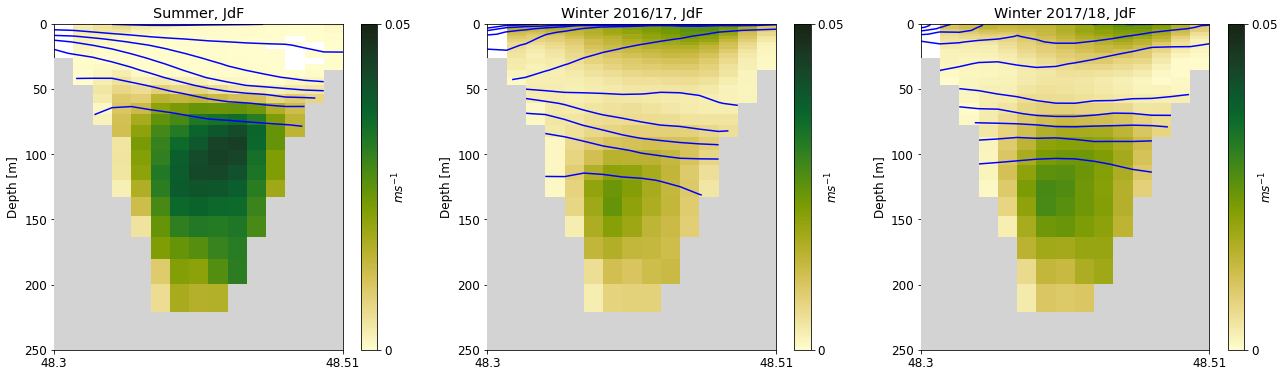

In [48]:
fig, ax = plt.subplots(1,3, figsize=[22,6])
JRFluxNS(Sdata, salfileS17, 'trans', init[1], init[2], init[3], init[4], ax[0], 'Summer, JdF')
JRFluxNS(Wdata16, salfileW16, 'trans', init[1], init[2], init[3], init[4], ax[1], 'Winter 2016/17, JdF')
JRFluxNS(Wdata17, salfileW17, 'trans', init[1], init[2], init[3], init[4], ax[2], 'Winter 2017/18, JdF')

# WM Flow

In [10]:
def FluxSpecificEW(lonW, lonE, figrid, maxdepth, ax, lons, trans, depth, high, salfile):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid, :]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[lonW-1:lonE+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    t_max = (high/np.sum(trans)).values

    dist = lons/m2lon
        
    H1, _, _ = np.histogram2d(dist, depth, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= trans, density= True)
    _, xedges, yedges = np.histogram2d(dist, depth, bins = bins)
            
    H_final = H1.T
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.speed
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    tick = np.round(((t_max*np.sum(trans)).values),2)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick]) 
    cb1.set_label('m/s', labelpad=-20, fontsize=14)
    
    xs, ys = np.meshgrid(np.array(t_dist[lonW-1:lonE+1]), np.array(t_depths))
    salinity = 0.5*(np.ma.array(salfile.vosaline[:, igrid, lonW-1:lonE+1],
            mask=1-tmask[:, igrid, lonW-1:lonE+1]) +
            np.ma.array(salfile.vosaline[:, igrid+1, lonW-1:lonE+1],
            mask=1-tmask[:, igrid+1, lonW-1:lonE+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW], t_dist[lonE-1]])
    ax.set_xticklabels(np.round([t_lons[lonW], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE-1]))
    ax.set_ylim((maxdepth, 0))
    # ax.set_title(str(title))
    ax.set_ylabel('Depth [m]', fontsize=14)
    mydata.close()

In [8]:
def FluxSpecificNS(latS, latN, fjgrid, maxdepth, ax, lats, trans, depth, high, salfile):
    jgrid = fjgrid-1
    fmask = mymesh.fmask[0, :, : ,jgrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[jgrid]
    time = mydata.init_t[-1]
    
    t_lats = mymesh.gphit[0, :, jgrid]
    m2lat = ((t_lats[latN]-t_lats[latS])/(mymesh.e2t[0, latS:latN, jgrid].sum()))
    t_dist = t_lats/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[latS-1:latN+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    t_max = (high/np.sum(trans)).values

    dist = lats/m2lat
        
    H1, _, _ = np.histogram2d(dist, depth, bins=bins,weights= trans, density= True)
    _, xedges, yedges = np.histogram2d(dist, depth, bins = bins)
            
    H_final = H1.T
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.speed
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    tick = np.round(((t_max*np.sum(trans)).values),2)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick]) 
    cb1.set_label('$m \, s^{-1}$', labelpad=-20, fontsize=14)
    
    xs, ys = np.meshgrid(np.array(t_dist[latS-1:latN+1]), np.array(t_depths))
    salinity = 0.5*(np.ma.array(salfile.vosaline[:, latS-1:latN+1, jgrid],
    mask=1-tmask[:, latS-1:latN+1, jgrid]) +
    np.ma.array(salfile.vosaline[:, latS-1:latN+1, jgrid+1],
    mask=1-tmask[:, latS-1:latN+1, jgrid+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,36, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[latS+1], t_dist[latN-2]])
    if latS == 259:
        ax.set_xticklabels(['USA','Canada'], fontsize=12)
    else:
        ax.set_xticklabels(np.round([t_lats[latS+1], t_lats[latN-2]],2))
    ax.set_xlim((t_dist[latS], t_dist[latN-1]))
    ax.set_ylim((maxdepth, 0))
    # ax.set_title(str(title))
    ax.set_ylabel('Depth [m]', fontsize=14)
    mydata.close()

### deep - salty salty

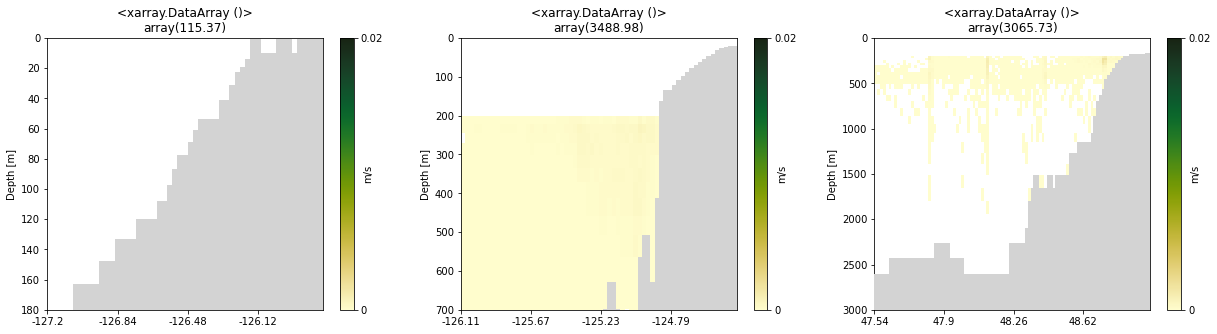

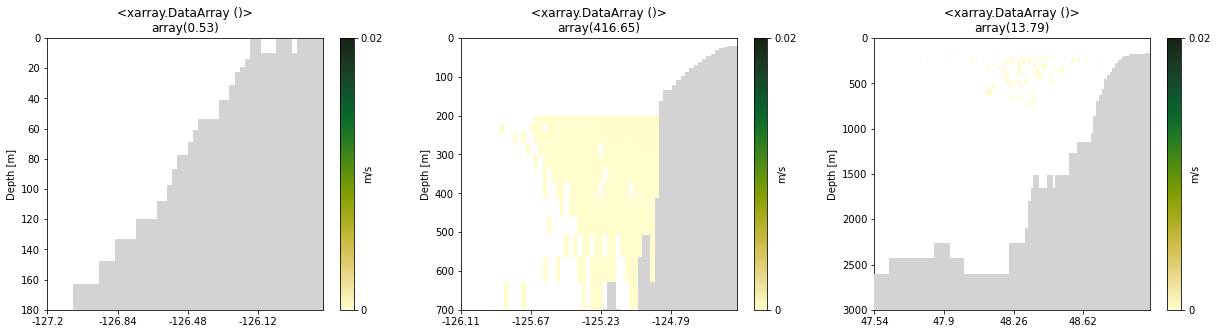

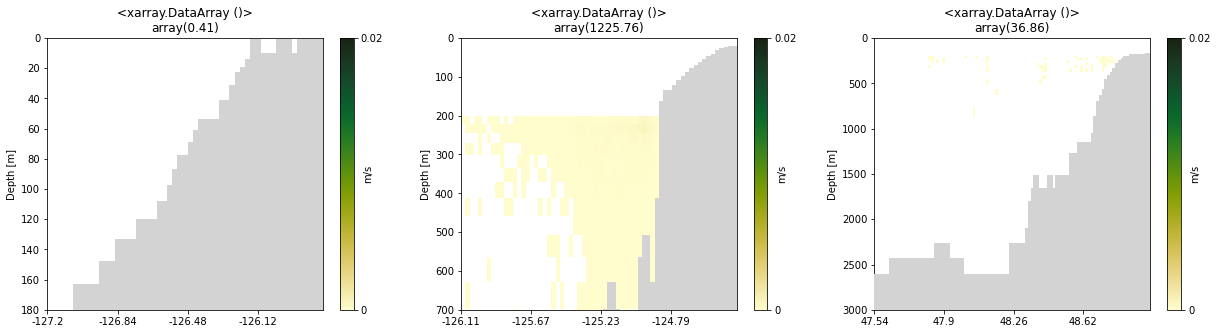

In [45]:
#summer 2017
high = 0.02
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, high)


#winter 2016/17
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, high)

#winter 2017/18
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, high)

### shallow - salty salty

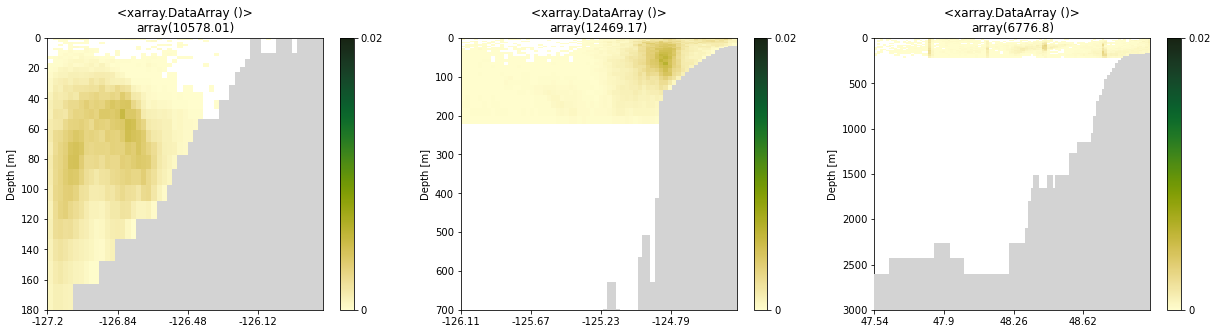

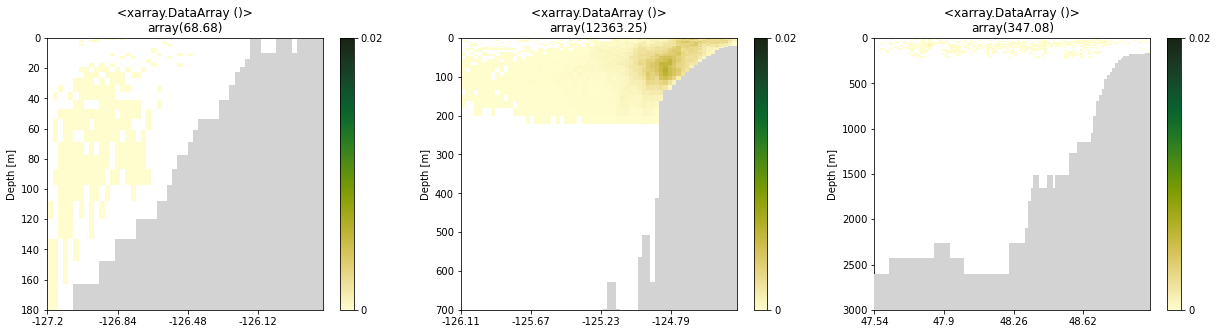

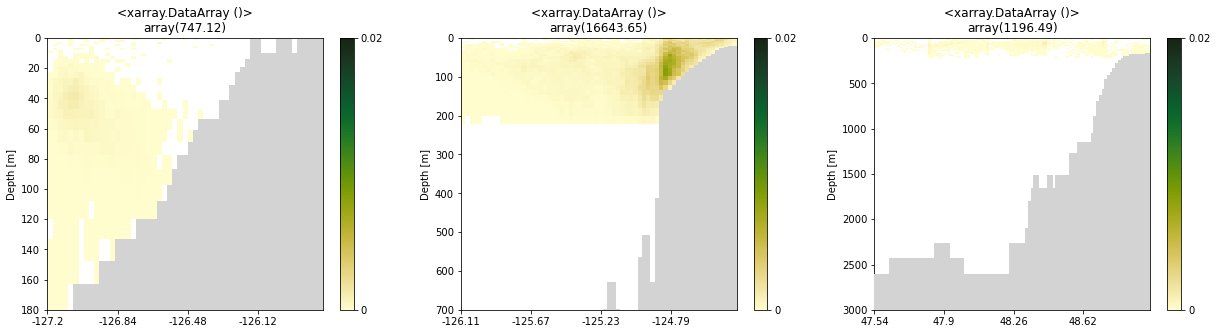

In [78]:
saltdiv = 32

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02)


#winter 2016/17
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02)

#winter 2017/18
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02)

### fresh

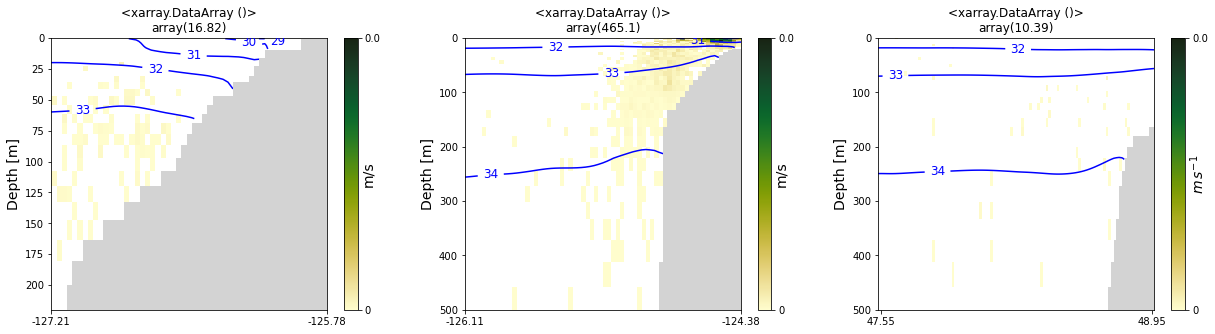

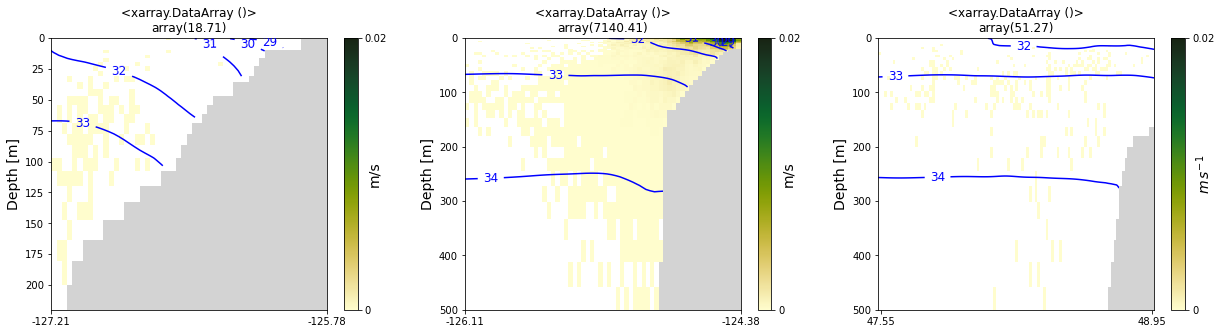

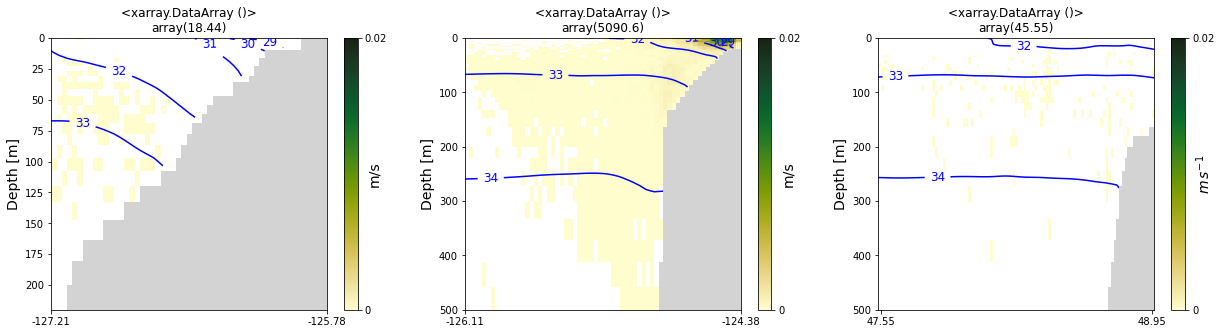

In [11]:
saltdiv=32
#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt <= saltdiv) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt <= saltdiv) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= saltdiv) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.002, salfileS17)

lons = mydata.final_lon[(mydata.init_salt < saltdiv) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt <= saltdiv) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= saltdiv) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.002, salfileS17)

lats = mydata.final_lat[(mydata.init_salt <= saltdiv) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt <= saltdiv) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= saltdiv) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.002, salfileS17)

#winter 2016/17
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt <= saltdiv) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt <= saltdiv) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= saltdiv) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02, salfileW16)

lons = mydata.final_lon[(mydata.init_salt <= saltdiv) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt <= saltdiv) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= saltdiv) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02, salfileW16)

lats = mydata.final_lat[(mydata.init_salt <= saltdiv) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt <= saltdiv) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= saltdiv) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02, salfileW16)

#winter 2017/18
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt <= saltdiv) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt <= saltdiv) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= saltdiv) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02, salfileW16)

lons = mydata.final_lon[(mydata.init_salt <= saltdiv) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt <= saltdiv) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= saltdiv) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02, salfileW16)

lats = mydata.final_lat[(mydata.init_salt <= saltdiv) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt <= saltdiv) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= saltdiv) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02, salfileW16)

## Where do these different groups enter JdF??

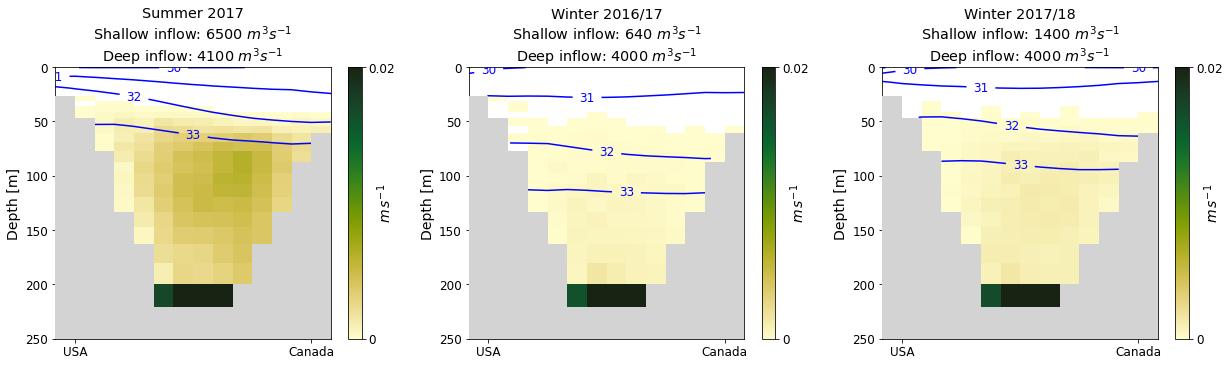

In [34]:
# deep salty salty
plt.rcParams['font.size'] = 12
salt = 32

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]
depth = depthf(mydata.init_z[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]/time
title = "Summer 2017\nShallow inflow: " + str(round_to_2(np.sum(trans[depth<200]).values))[:-2] + " $m^3 s^{-1}$"+ "\nDeep inflow: "+ str(round_to_2(np.sum(trans[depth>=200]).values))[:-2] + " $m^3 s^{-1}$"
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileS17)


# winter 2016/17

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]
depth = depthf(mydata.init_z[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]/time
title = "Winter 2016/17\nShallow inflow: " + str(round_to_2(np.sum(trans[depth<200]).values))[:-2] + " $m^3 s^{-1}$"+ "\nDeep inflow: "+ str(round_to_2(np.sum(trans[depth>=200]).values))[:-2] + " $m^3 s^{-1}$"
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileW16)

#winter 2017/18

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]
depth = depthf(mydata.init_z[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]/time
title = "Winter 2017/18\nShallow inflow: " + str(round_to_2(np.sum(trans[depth<200]).values))[:-2] + " $m^3 s^{-1}$"+ "\nDeep inflow: "+ str(round_to_2(np.sum(trans[depth>=200]).values))[:-2] + " $m^3 s^{-1}$"
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02, salfileW17)

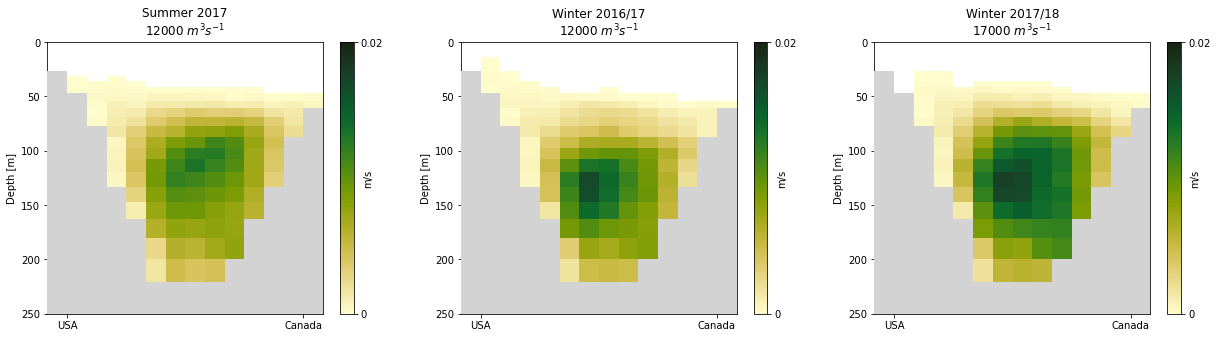

In [71]:
# shallow salty salty

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

# lats = mydata.init_lat[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]
# depth = depthf(mydata.init_z[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]-1.)[0]
# trans = mydata.init_transp[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]/time
title = "Summer 2017\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02)


#winter 2016/17

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]
depth = depthf(mydata.init_z[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]-1.)[0]
trans = mydata.init_transp[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]/time
title = "Winter 2016/17\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02)

#winter 2017/18

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]
depth = depthf(mydata.init_z[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]-1.)[0]
trans = mydata.init_transp[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]/time
title = "Winter 2017/18\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02)

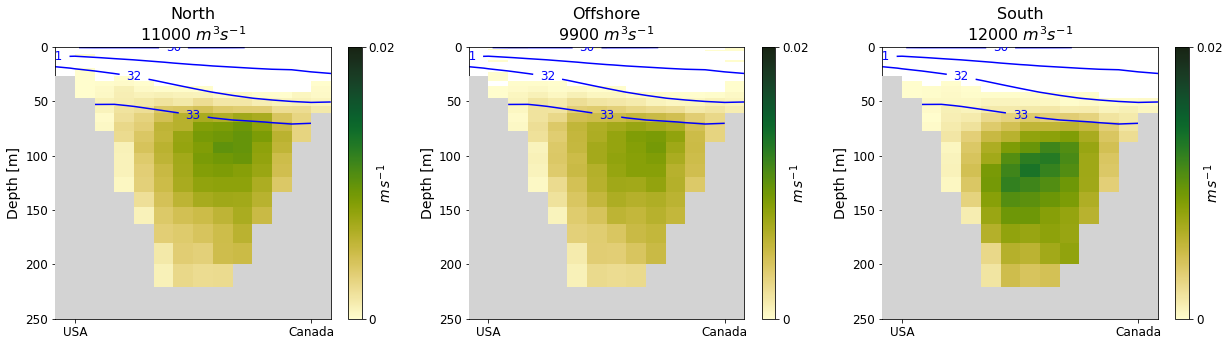

In [32]:
# do the shallow salty salty from different directions in the summer of 2017 enter the JdF differently????
# shallow salty salty
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.final_section == North[0])]
depth = depthf(mydata.init_z[(mydata.final_section == North[0])]-1.)[0]
trans = mydata.init_transp[(mydata.final_section == North[0])]/time
title = "North\n"  + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$"  
ax[0].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileS17)

lats = mydata.init_lat[(mydata.final_section == offshore[0])]
depth = depthf(mydata.init_z[(mydata.final_section == offshore[0])]-1.)[0]
trans = mydata.init_transp[(mydata.final_section == offshore[0])]/time
title = "Offshore\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileS17)

lats = mydata.init_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "South\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02, salfileS17)

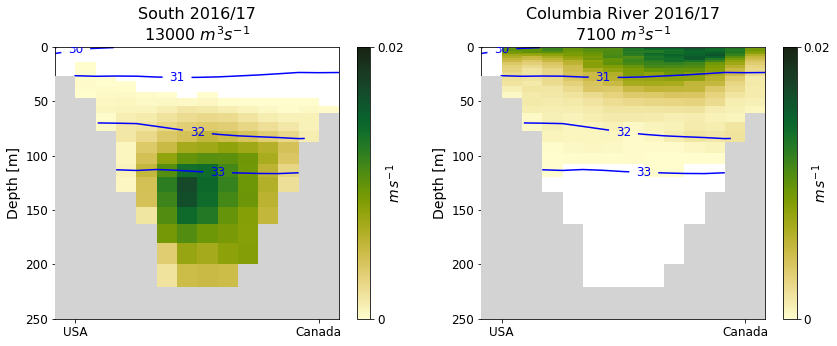

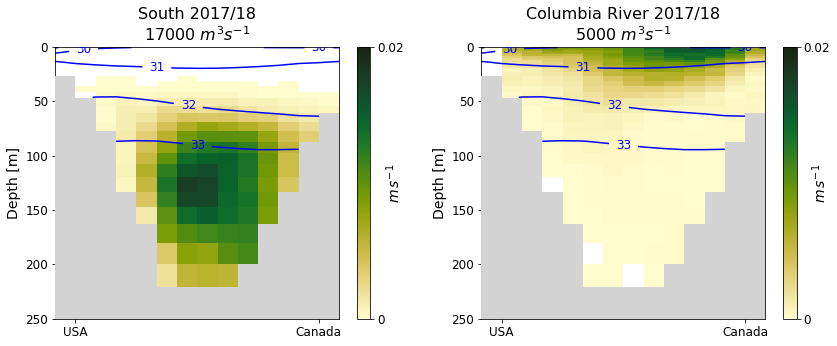

In [33]:
# one plot of fresh and south entering JdF in the winter
# 2016/17
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(1,2,figsize=(14,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "South\n" + str(np.round(np.sum(trans),0).values)
title = "South 2016/17\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileW16)

lats = mydata.init_lat[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "Columbia River\n" + str(np.round(np.sum(trans),0).values)
title = "Columbia River 2016/17\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileW16)

# 2017/18
fig, ax = plt.subplots(1,2,figsize=(14,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "South\n" + str(np.round(np.sum(trans),0).values)
title = "South 2017/18\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileW17)

lats = mydata.init_lat[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "Columbia River\n" + str(np.round(np.sum(trans),0).values)
title = "Columbia River 2017/18\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileW17)

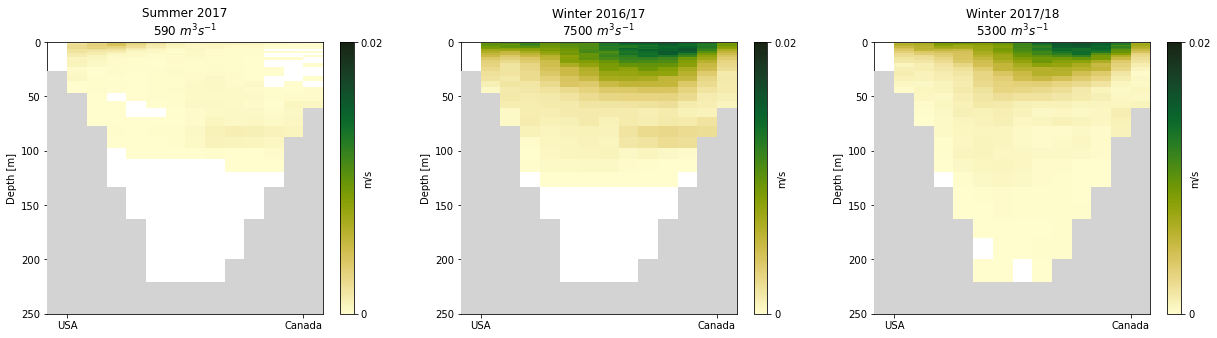

In [76]:
# fresh

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200)& np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "Summer 2017\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02)


#winter 2016/17

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "Winter 2016/17\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02)

#winter 2017/18

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "Winter 2017/18\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02)